## Tijdsduur berekenen naar volgend meetpunt en visualiseren

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np


In [2]:
# inlezen 2 weken selectie uit totale dataset
locatus = pd.read_csv('locatus_jan_2018-v2wk.csv',delimiter=';')
#id
#VirtualSensorCode
#DateTimeLocal
#Duration
#code_address

In [3]:
#ivm foute regels / dubbele headers in bestand, deze verwijderen
locatus = locatus[locatus.DateTimeLocal != 'DateTimeLocal']

In [4]:
# verwijderen column 'Duration'. Deze geeft verkeerde waarden weer en wordt later weer berekend.
locatus = locatus.drop('Duration',axis=1)

In [5]:
# omzetten veld types

locatus['VirtualSensorCode'] = locatus['VirtualSensorCode'].astype(str)
locatus['code_address'] = locatus['code_address'].astype(str)
locatus['Datumtijd'] = locatus['DateTimeLocal'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S' )) #bijzonder traag!
locatus['Datum'] = locatus['DateTimeLocal'].str[:10]  #eerste 10 tekens
locatus['Unixdatetime'] = locatus['DateTimeLocal'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S' ).timestamp()).astype(int)

In [6]:
# sorteren dataframe, eerst device code, daarbinnen op timestamp
locatus.sort_values(['code_address', 'Unixdatetime'], ascending=[True, True], inplace=True)

In [7]:
#waarden uit vorige regel ophalen
locatus['Vorig_code_address'] = locatus.code_address.shift()
locatus['Vorig_Unixdatetime'] = locatus.Unixdatetime.shift()

In [8]:
#waarden vergelijken en tijdsduur (seconden) tussen 2 opeenvolgende waarnemingen van een device bepalen
locatus['Tijdsduur'] = np.where(locatus.Vorig_code_address == locatus.code_address, locatus.Unixdatetime - locatus.Vorig_Unixdatetime,0) 
locatus['Vorig_opstelpunt'] = np.where(locatus.code_address == locatus.code_address.shift(),locatus.VirtualSensorCode.shift(),'' )

In [9]:
#onnodige kolommen verwijderen
locatus = locatus.drop('Vorig_code_address',axis=1)
locatus = locatus.drop('Vorig_Unixdatetime',axis=1)
locatus = locatus.drop('id',axis=1)

In [10]:
#selectie maken
selectie = locatus
selectie = selectie[selectie['Datum'] == '2018-01-08']
#selectie = selectie[selectie['code_address'] == '1368474']
#selectie = selectie[selectie['VirtualSensorCode'] == '1079'] 
selectie = selectie[selectie['Vorig_opstelpunt'] == '1074'] 
selectie = selectie[selectie.Tijdsduur < 1000]
#selectie = selectie[selectie.code_address == '1368474']

In [11]:
#maak een free account aan op plot.ly
#plotly.tools.set_credentials_file(username='', api_key='')

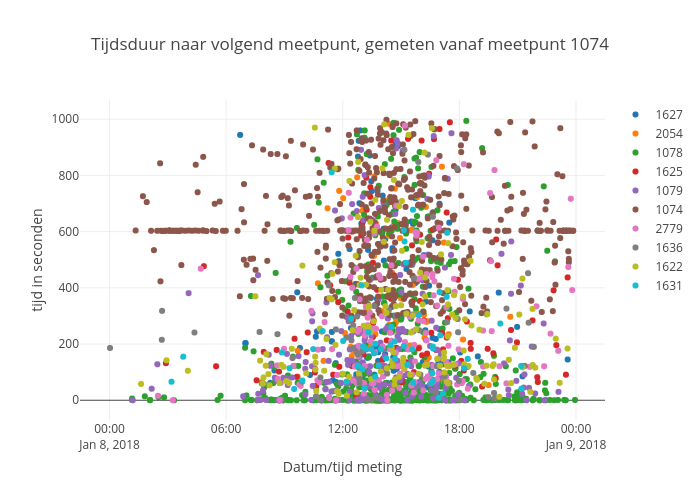

In [12]:
#plot maken
traces = []
for cls in selectie['VirtualSensorCode'].unique():
    traces.append({
        'type' : 'scatter',
        'mode' : 'markers',
        'x' : selectie.Datumtijd[selectie['VirtualSensorCode'] == cls],
        'y' : selectie.Tijdsduur[selectie['VirtualSensorCode'] == cls],
        'name' : cls
    })
fig = {
    'data' : traces,
    'layout' : {
        'title' : 'Tijdsduur naar volgend meetpunt, gemeten vanaf meetpunt ' + selectie.iat[0,7],
        'xaxis' : {
            'title' : 'Datum/tijd meting',
        },
        'yaxis' : {
            'title' : 'tijd in seconden'
        }
    }
}

py.image.ishow(fig)    

trace = go.Scattergl(
    x = selectie.Datumtijd,
    y = selectie.Tijdsduur,
    mode = 'markers',
    name = selectie.Vorig_opstelpunt
)
data = [trace]
py.iplot(data, filename='TijdsduurTussenMeetpunten')